In [1]:
using PyCall
using Knet
using Images
@pyimport gym

env = gym.make("Asterix-v0")

function render(env)
    return env[:render](mode="render_rgb")
end

function step!(env, action)
    return env[:step](action)
end

function reset!(env)
    return env[:reset]()
end

function seed(env, seed_num)
    env[:seed](seed_num)
end

function action_count(env)
    return env[:action_space][:n]
end

function sample_action(env)
    return env[:action_space][:sample]()
end

sample_action (generic function with 1 method)

In [2]:
function preprocess_img(img;viewable = false)
    out = img./255.0
    out = Gray.(out)[:,:,1]
    out = imresize(out, (110, 84))
    out =  out[27:110,:,:]
    out = reshape(out, (84,84))
    if(!viewable)
        out = Float64.(out)
    end
    return out
end

preprocess_img (generic function with 1 method)

In [3]:
state = reset!(env)
println(summary(state))
obs, reward, done, info = step!(env,sample_action(env))

210×160×3 Array{UInt8,3}


(UInt8[0x00 0x00 … 0x00 0x00; 0x00 0x00 … 0x00 0x00; … ; 0x00 0x00 … 0x00 0x00; 0x00 0x00 … 0x00 0x00]

UInt8[0x00 0x00 … 0x00 0x00; 0x00 0x00 … 0x00 0x00; … ; 0x00 0x00 … 0x00 0x00; 0x00 0x00 … 0x00 0x00]

UInt8[0x00 0x00 … 0x00 0x00; 0x00 0x00 … 0x00 0x00; … ; 0x00 0x00 … 0x00 0x00; 0x00 0x00 … 0x00 0x00], 0.0, false, Dict{Any,Any}(Pair{Any,Any}("ale.lives", 3)))

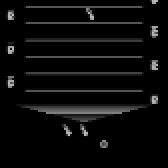

In [4]:
test_img = preprocess_img(obs;viewable = true)

In [5]:
println(summary(test_img))

84×84 Array{Gray{Float64},2}


In [6]:
function winit(atype = Float32)
    w = Any[]
    push!(w, 0.1 * randn(atype,8,8,1,32))
    push!(w, 0.1 * randn(atype,4,4,32,64))
    push!(w, 0.1 * randn(atype,3,3,64,64))
    push!(w, 0.1 * randn(atype,512,3136))
    push!(w, 0.1 * zeros(atype,512,1))
    push!(w, 0.1 * randn(atype,action_count(env),512))
    push!(w, 0.1 * randn(atype,action_count(env),1))
    return w
end

winit (generic function with 2 methods)

In [7]:
w = winit()
for wi in w
    println(summary(wi))
end

8×8×1×32 Array{Float64,4}
4×4×32×64 Array{Float64,4}
3×3×64×64 Array{Float64,4}
512×3136 Array{Float64,2}
512×1 Array{Float64,2}
9×512 Array{Float64,2}
9×1 Array{Float64,2}


In [8]:
function model(obs)
    global w
    input = preprocess_img(obs)
    input = reshape(input, (84, 84, 1, 1))
    output = conv4(w[1], input; stride=4)
    output = relu.(output)
    output = conv4(w[2], output; stride=2)
    output = relu.(output)
    output = conv4(w[3], output; stride=1)
    output = relu.(output)
    output = relu.(w[4] * mat(output) .+ w[5])
    output = w[6] * mat(output) .+ w[7]
    return output
end

model (generic function with 1 method)

In [9]:
result = model(obs)

9×1 Array{Float64,2}:
 -0.272084 
  0.456103 
 -0.878999 
 -0.335212 
 -0.0120074
 -0.214524 
  1.68447  
  0.0692988
 -0.603031 